In [1]:
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pillow_heif import register_heif_opener
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.optimizer import Adam
import fastai.callback.schedule
from fastai.callback.progress import ShowGraphCallback

register_heif_opener()

In [2]:
device = torch.device("cuda")

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    
    def forward(self, x, resid):
        x = F.relu(self.up_conv(x))
        assert x.shape == resid.shape
        x = torch.cat((resid, x), dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.enc1 = EncoderBlock(64, 128)
        self.enc2 = EncoderBlock(128, 256)
        self.enc3 = EncoderBlock(256, 512)
        self.enc4 = EncoderBlock(512, 1024)
        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)
        self.head = nn.Conv2d(64, 3, 1, padding='same')
        # Max of each output channel
        # max_out = (255.0 - mean * 255.0) / (std * 255.0)
        # Min of each output channel
        # min_out = (0.0 - mean * 255.0) / (std * 255.0)
        self.max_out = nn.Parameter(torch.tensor([2.2489083, 2.42857143, 2.64]).view(1, -1, 1, 1))
        self.min_out = nn.Parameter(torch.tensor([-2.11790393, -2.03571429, -1.80444444]).view(1, -1, 1, 1))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x0 = x
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)

        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)
        x = self.head(x)
        x = torch.sigmoid(x)
        # converting [0, 1] to [min_out, max_out]
        x = x * (self.max_out - self.min_out) + self.min_out
        return x

In [3]:
class ColoringDataset(Dataset):
    def __init__(self, train):
        if train:
            base_path = "train_images"
            self.transforms = A.Compose([
                A.SmallestMaxSize(int(512 * 3 / 2)),
                A.RandomCrop(height=384, width=512),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
        else:
            base_path = "val_images"
            self.transforms = A.Compose([
                A.Resize(height=384, width=512),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])

        self.image_paths = glob("%s/*.*" % base_path)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = np.array(image)
        image = self.transforms(image=image)["image"]

        grey_image = torch.mean(image, dim=0, keepdim=True)
        return grey_image, image

In [4]:
train_dataset = ColoringDataset(train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=8)

val_dataset = ColoringDataset(train=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, num_workers=8)

In [5]:
data = DataLoaders(train_loader, val_loader)
learner = Learner(data, UNet(), loss_func=F.mse_loss, opt_func=Adam)

SuggestedLRs(valley=0.0020892962347716093)

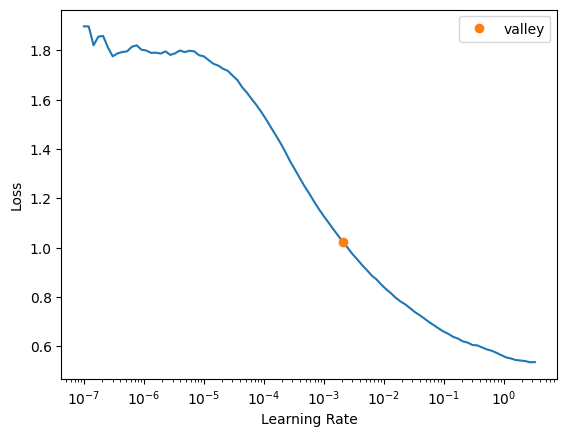

In [6]:
learner.lr_find()

epoch,train_loss,valid_loss,time
0,0.135357,0.132654,05:05
1,0.128277,0.125518,05:05
2,0.112963,0.117289,05:06
3,0.116094,0.123867,05:05
4,0.112265,0.119264,05:05
5,0.115500,0.125930,05:06
6,0.111493,0.122464,05:06
7,0.110584,0.146267,05:06
8,0.120723,0.126793,05:06
9,0.111204,0.116283,05:05


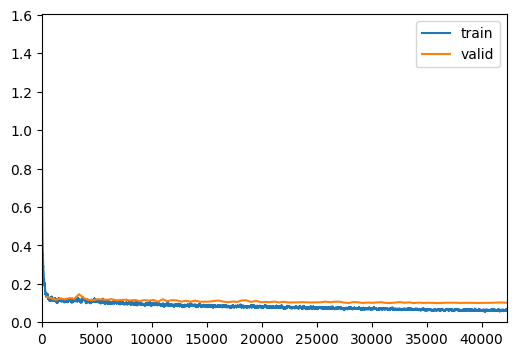

Path('models/ckpt.pth')

In [6]:
learner.fit_one_cycle(100, lr_max=2e-3, cbs=[ShowGraphCallback()])
learner.save("ckpt")

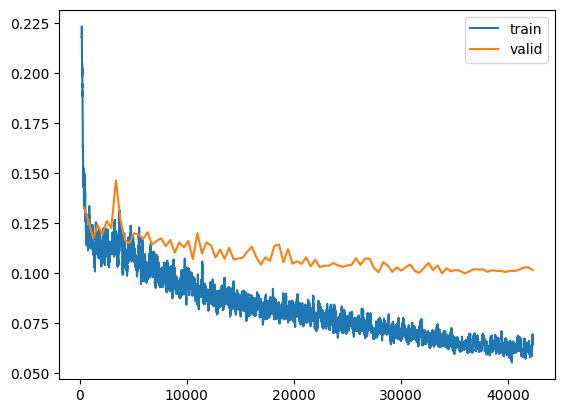

In [16]:
learner.recorder.plot_loss(skip_start=200)

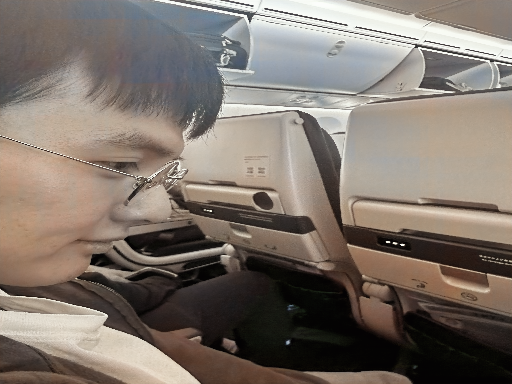

In [7]:
x, y = next(iter(val_loader))
x = x.to(device)

with torch.no_grad():
    output = learner.model(x)
    output = output[0].permute((1, 2, 0))
    output *= torch.tensor([0.229, 0.224, 0.225], device=device) * 255.0
    output += torch.tensor([0.485, 0.456, 0.406], device=device) * 255.0
    output = torch.clamp(output.byte(), 0, 255)
    output = output.cpu().numpy()

Image.fromarray(output)

In [13]:
# https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
# img = (img - mean * max_pixel_value) / (std * max_pixel_value)
import torch
mean=torch.tensor((0.485, 0.456, 0.406))
std=np.array((0.229, 0.224, 0.225))

In [14]:
mean

tensor([0.4850, 0.4560, 0.4060])

In [12]:
# Max of each output channel
max_out = (255.0 - mean * 255.0) / (std * 255.0)
# Min of each output channel
min_out = (0.0 - mean * 255.0) / (std * 255.0)

In [16]:
max_out, min_out

(array([2.2489083 , 2.42857143, 2.64      ]),
 array([-2.11790393, -2.03571429, -1.80444444]))

In [10]:
# [0, 1] -> [min_out, max_out]
# output * (max_out - min_out) - min_out

array([-2.11790393, -2.03571429, -1.80444444])